Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.86MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.95MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/50], Train Loss: 0.2898, Validation Loss: 0.2478
Epoch [2/50], Train Loss: 0.2402, Validation Loss: 0.2330
Epoch [3/50], Train Loss: 0.2156, Validation Loss: 0.1918
Epoch [4/50], Train Loss: 0.1851, Validation Loss: 0.1752
Epoch [5/50], Train Loss: 0.1721, Validation Loss: 0.1685
Epoch [6/50], Train Loss: 0.1653, Validation Loss: 0.1605
Epoch [7/50], Train Loss: 0.1598, Validation Loss: 0.1555
Epoch [8/50], Train Loss: 0.1562, Validation Loss: 0.1531
Epoch [9/50], Train Loss: 0.1533, Validation Loss: 0.1494
Epoch [10/50], Train Loss: 0.1502, Validation Loss: 0.1472
Epoch [11/50], Train Loss: 0.1483, Validation Loss: 0.1460
Epoch [12/50], Train Loss: 0.1467, Validation Loss: 0.1445
Epoch [13/50], Train Loss: 0.1452, Validation Loss: 0.1427
Epoch [14/50], Train Loss: 0.1434, Validation Loss: 0.1406
Epoch [15/50], Train Loss: 0.1415, Validation Loss: 0.1386
Epoch [16/50], Train Loss: 0.1399, Validation Loss: 0.1375
Epoch [17/50], Train Loss: 0.1387, Validation Loss: 0.1360
Epoch 

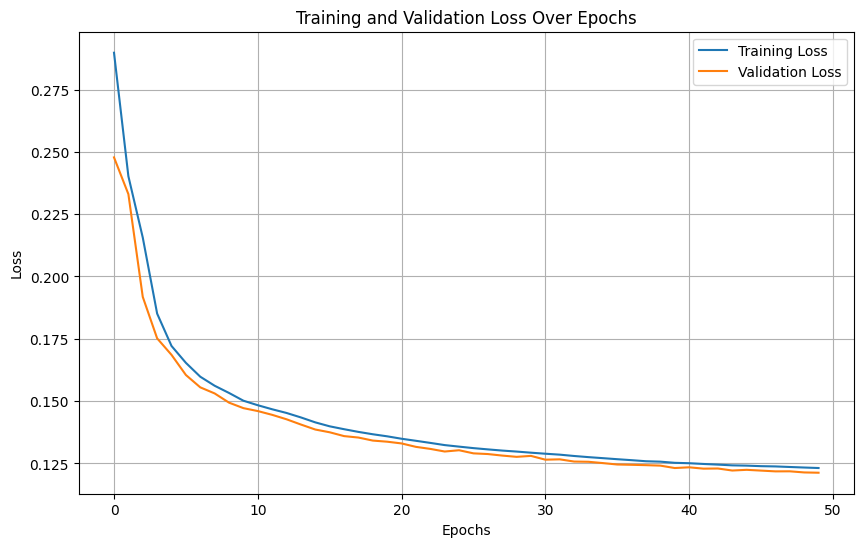

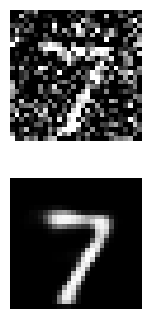

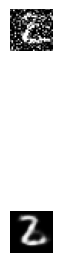

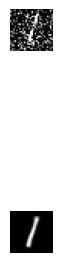

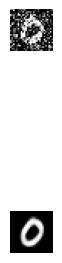

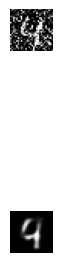

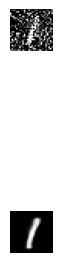

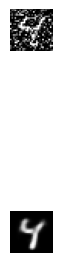

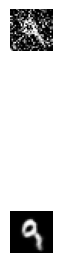

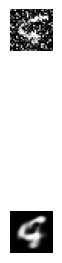

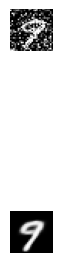

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * torch.randn_like(data)
    return torch.clamp(noisy_data, 0., 1.)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        noisy_data = add_noise(data.view(-1, 28 * 28))
        optimizer.zero_grad()
        outputs = model(noisy_data)
        loss = criterion(outputs, data.view(-1, 28 * 28))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            noisy_data = add_noise(data.view(-1, 28 * 28))
            outputs = model(noisy_data)
            loss = criterion(outputs, data.view(-1, 28 * 28))
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    denoised_images = []
    for data, _ in test_loader:
        noisy_data = add_noise(data.view(-1, 28 * 28))
        outputs = model(noisy_data)
        denoised_images.append(outputs.view(-1, 1, 28, 28))

    denoised_images = torch.cat(denoised_images)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(add_noise(test_dataset.data[i].float() / 255.).view(28, 28).numpy(), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_images[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
